# Phil's Data Wrangling Project

### Project Details

Your tasks in this project are as follows:

- Data wrangling, which consists of:
    - Gathering data (downloadable file in the Resources tab in the left most panel of your classroom and linked in step 1 below).
    - Assessing data
    - Cleaning data
- Storing, analyzing, and visualizing your wrangled data
- Reporting on 1) your data wrangling efforts and 2) your data analyses and visualizations

### Gather Data

- The WeRateDogs Twitter archive - twitter_archive_enhanced.csv is saved in Notebook root directory, Data Sources folder.
- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
- Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

In [1]:
# import packages
import pandas as pd
import requests
import os
import json
import numpy as np

# had to install this for my environment with pip install tweepy
import tweepy

In [2]:
# read in Twitter archive CSV file, check it worked
archive_df = pd.read_csv('Data Sources/twitter-archive-enhanced.csv')
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [3]:
# download image predictions data
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
folder_name = 'Data Sources'

# use requests library
response = requests.get(url)
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

# check it worked
assert os.path.exists('Data Sources/image-predictions.tsv')

In [4]:
# read in the predictions tsv file, check it worked
predictions_df = pd.read_csv('Data Sources/image-predictions.tsv', sep='\t')
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [5]:
# set up tweepy authorisation
with open('Data Sources/twatter_bearer.txt', 'r') as file:
    myToken = file.readline()

# tweepy.API gave an authorisation error, using Client (Twitter API v2) instead
client = tweepy.Client(bearer_token=myToken, return_type=requests.Response, wait_on_rate_limit=True)

In [173]:
# Twitter API v2 seems to be more constrained in responses than v1.1
# will get public metrics and append JSON content directly to a dataframe rather than save extended tweet info to a .txt file and read back in
tweets_df = pd.DataFrame()

# break data up into chunks of size 100 to reduce number of requests to Twitter API
ids_chunked_list = [archive_df['tweet_id'][i:i+100] for i in range(0, len(archive_df),100)]

# iterate over our chunks, passing a list of tweet ids in each chunk as input to tweepy get_tweets
counter = 0
for tweet_ids in ids_chunked_list:
    tweets = client.get_tweets(ids=tweet_ids.to_list(), tweet_fields='public_metrics')
    if tweets.status_code != 200:
        print('Chunk ' + str(counter) + ': Request returned an error: {} {}'.format(tweets.status_code, tweets.text))
        counter = counter + 1
    else:
        tweets_json = tweets.json()
        # write to tweet_json in case needed later, but for this project we'll normalise straight into a dataframe
        with open('Data Sources/tweet_json.txt', 'w') as jfile:
            json.dump(tweets_json, jfile)
        try:
            tweets_df = tweets_df.append(pd.json_normalize(tweets_json['data']))
            print('Chunk ' + str(counter) + ' public metrics appended to tweets_df')
            counter = counter + 1
        except:
            print('Something went wrong!')

tweets_df   

Chunk 0 public metrics appended to tweets_df
Chunk 1 public metrics appended to tweets_df
Chunk 2 public metrics appended to tweets_df
Chunk 3 public metrics appended to tweets_df
Chunk 4 public metrics appended to tweets_df
Chunk 5 public metrics appended to tweets_df
Chunk 6 public metrics appended to tweets_df
Chunk 7 public metrics appended to tweets_df
Chunk 8 public metrics appended to tweets_df
Chunk 9 public metrics appended to tweets_df
Chunk 10 public metrics appended to tweets_df
Chunk 11 public metrics appended to tweets_df
Chunk 12 public metrics appended to tweets_df
Chunk 13 public metrics appended to tweets_df
Chunk 14 public metrics appended to tweets_df
Chunk 15 public metrics appended to tweets_df
Chunk 16 public metrics appended to tweets_df
Chunk 17 public metrics appended to tweets_df
Chunk 18 public metrics appended to tweets_df
Chunk 19 public metrics appended to tweets_df
Chunk 20 public metrics appended to tweets_df
Chunk 21 public metrics appended to tweets_d

,id,text,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,7083,144,34151,219
1,892177421306343426,This is Tilly. She's just checking pup on you....,5344,172,29627,274
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,3515,110,22306,145
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,7286,142,37336,286
4,891327558926688256,This is Franklin. He would like you to stop ca...,7823,193,35665,296
...,...,...,...,...,...,...
51,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,37,9,90,0
52,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,117,1,250,2
53,666033412701032449,Here is a very happy pup. Big fan of well-main...,36,1,101,0
54,666029285002620928,This is a western brown Mitsubishi terrier. Up...,39,0,115,0


### Assessing Data

Detect and document at least eight (8) quality issues and two (2) tidiness issues using both visual assessment and programmatic assessement to assess the data. Pay attention to the following key points when you access the data.

- You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

In [7]:
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [8]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [10]:
# check these flagging columns only contain one value, repeat for doggo, floofer, pupper
archive_df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [11]:
# check for duplicate tweets
archive_df['tweet_id'][archive_df.tweet_id.duplicated()]

Series([], Name: tweet_id, dtype: int64)

In [12]:
archive_df.name.sort_values()

1035     Abby
1021     Abby
938       Ace
1933     Acro
1327    Adele
        ...  
1031     very
773      very
1097     very
819      very
1385     very
Name: name, Length: 2356, dtype: object

In [13]:
archive_df.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [14]:
predictions_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [15]:
predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [17]:
predictions_df.sort_values(by='p1_conf', ascending=False)
# some confident predictions there... we'll leave those as they are

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
106,667866724293877760,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,jigsaw_puzzle,1.000000,False,prayer_rug,1.011300e-08,False,doormat,1.740170e-10,False
1299,752519690950500352,https://pbs.twimg.com/media/CnF8qVDWYAAh0g1.jpg,3,swing,0.999984,False,Labrador_retriever,1.002880e-05,True,Eskimo_dog,1.434470e-06,True
1229,745433870967832576,https://pbs.twimg.com/media/ClhQJUUWAAEVpBX.jpg,1,barrow,0.999962,False,basset,1.448950e-05,True,wok,6.060880e-06,False
149,668636665813057536,https://pbs.twimg.com/media/CUd5gBGWwAA0IVA.jpg,1,komondor,0.999956,True,llama,4.309810e-05,False,ram,2.160900e-07,False
1372,762464539388485633,https://pbs.twimg.com/media/CpTRc4DUEAAYTq6.jpg,4,chow,0.999953,True,Tibetan_mastiff,2.335910e-05,True,dhole,3.010330e-06,False
...,...,...,...,...,...,...,...,...,...,...,...,...
246,670474236058800128,https://pbs.twimg.com/media/CU4AwqQWUAAEgE2.jpg,1,wool,0.070076,False,siamang,6.253600e-02,False,gorilla,5.889360e-02,False
1370,762035686371364864,https://pbs.twimg.com/ext_tw_video_thumb/76203...,1,home_theater,0.063152,False,cash_machine,4.669210e-02,False,theater_curtain,4.627680e-02,False
1093,719704490224398336,https://pbs.twimg.com/media/CfznaXuUsAAH-py.jpg,1,home_theater,0.059033,False,window_shade,3.829900e-02,False,bathtub,3.552820e-02,False
136,668507509523615744,https://pbs.twimg.com/media/CUcECBYWcAAzFRg.jpg,1,basenji,0.055379,True,Shetland_sheepdog,5.432210e-02,True,whippet,5.191340e-02,True


In [18]:
# check for duplicate tweets
predictions_df['tweet_id'][predictions_df.tweet_id.duplicated()]

Series([], Name: tweet_id, dtype: int64)

In [19]:
tweets_df

,id,text,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,7083,144,34153,219
1,892177421306343426,This is Tilly. She's just checking pup on you....,5344,172,29626,274
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,3515,110,22307,145
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,7286,142,37337,286
4,891327558926688256,This is Franklin. He would like you to stop ca...,7823,193,35666,296
...,...,...,...,...,...,...
51,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,37,9,90,0
52,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,117,1,250,2
53,666033412701032449,Here is a very happy pup. Big fan of well-main...,36,1,101,0
54,666029285002620928,This is a western brown Mitsubishi terrier. Up...,39,0,115,0


In [20]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 55
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            2327 non-null   object
 1   text                          2327 non-null   object
 2   public_metrics.retweet_count  2327 non-null   int64 
 3   public_metrics.reply_count    2327 non-null   int64 
 4   public_metrics.like_count     2327 non-null   int64 
 5   public_metrics.quote_count    2327 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 127.3+ KB


#### Quality issues
1. Archive data (archive_df) timestamp has '+0000' at the end of each value and is stored as string rather than datetime
2. Archive data (archive_df) name is sometimes incorrectly identified as 'a' or 'very'
3. Archive data (archive_df) name contains 'None' rather than null values
4. Archive data (archive_df) doggo, floofer, pupper and puppo columns contain 'None' values rather than null values
5. Archive data (archive_df) contains replies, identified by an ID in in_reply_to_status_id column
6. Archive data (archive_df) contains retweets, identified by an ID in retweeted_status_id column
7. Archive data (archive_df) contains tweets with no image link in expanded_urls column
8. Predictions data (predictions_df) is missing some records (2075 rows compared to 2356 in archive data)
9. Predictions data (predictions_df) predictions are inconsistently formatted: 'redbone', 'German_shepherd'
10. Metrics data (tweets_df) is missing some records (2327 compared to 2356 in archive data)
11. Metrics data (tweets_df) id field is string format rather than integer

#### Tidiness issues
1. Metrics data obtained via API (tweets_df) is in a separate dataframe to archive data (archive_df), should be in same
2. Predictions data column headers are not descriptive
3. Predictions data predictions 1-3 are split across multiple columns, should be in rows


### Cleaning Data

NOTE: Quality issues 8 and 10 relate to missing data, which we cannot rectify, these will not be cleaned

In [21]:
# make copies of existing data in case we need to revert back to it
archive_clean = archive_df.copy()
predictions_clean = predictions_df.copy()
tweets_clean = tweets_df.copy()

##### Quality Issue #11: Metrics data (tweets_df) id field is string format rather than integer

Define: Convert id field to integer using pd.astype

Code:

In [22]:
tweets_clean.id = tweets_clean.id.astype('int64')

Test:

In [23]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2327 entries, 0 to 55
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            2327 non-null   int64 
 1   text                          2327 non-null   object
 2   public_metrics.retweet_count  2327 non-null   int64 
 3   public_metrics.reply_count    2327 non-null   int64 
 4   public_metrics.like_count     2327 non-null   int64 
 5   public_metrics.quote_count    2327 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 127.3+ KB


##### Tidiness Issue #1: Metrics data obtained via API (tweets_df) is in a separate dataframe to archive data (archive_df), should be in same

Define: Merge Archive data (archive_clean) and Metrics data (tweets_clean) into one dataframe

Code:

In [24]:
# first let's drop the duplicate text column from tweets_clean
tweets_clean.drop(columns='text', inplace=True)

In [25]:
# then merge together, keeping all records from archive data
archive_clean = pd.merge(left=archive_clean, right=tweets_clean, how='left', left_on='tweet_id', right_on='id')
archive_clean.drop(columns='id', inplace=True)

Test:

In [26]:
archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,public_metrics.quote_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,None,None,None,7083.0,144.0,34153.0,219.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,None,None,None,None,5344.0,172.0,29626.0,274.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,None,None,None,None,3515.0,110.0,22307.0,145.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,None,None,None,None,7286.0,142.0,37337.0,286.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,None,None,None,None,7823.0,193.0,35666.0,296.0


In [27]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      2356 non-null   int64  
 1   in_reply_to_status_id         78 non-null     float64
 2   in_reply_to_user_id           78 non-null     float64
 3   timestamp                     2356 non-null   object 
 4   source                        2356 non-null   object 
 5   text                          2356 non-null   object 
 6   retweeted_status_id           181 non-null    float64
 7   retweeted_status_user_id      181 non-null    float64
 8   retweeted_status_timestamp    181 non-null    object 
 9   expanded_urls                 2297 non-null   object 
 10  rating_numerator              2356 non-null   int64  
 11  rating_denominator            2356 non-null   int64  
 12  name                          2356 non-null   object 
 13  dog

##### Tidiness Issue #2 and #3: Predictions data column headers are not descriptive, Predictions data predictions 1-3 are split across multiple columns, should be in rows

Define: Issue #2 will be rectified in cleaning issue #3. For issue #3, unpivot the Predictions data (predictions_clean) using pd.wide_to_long, resulting in four columns for predictions: prediction_number, predicted_breed, prediction_is_dog, prediction_confidence.

Code:

In [28]:
# reminder of columns in predictions data...
list(predictions_clean.columns)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [29]:
# rename some columns to prep for pd.wide_to_long function
predictions_clean.rename(columns={'p1':'predicted_breed_1', 'p1_conf':'prediction_confidence_1', 'p1_dog':'prediction_is_dog_1'
                                    , 'p2':'predicted_breed_2', 'p2_conf':'prediction_confidence_2', 'p2_dog':'prediction_is_dog_2'
                                    , 'p3':'predicted_breed_3', 'p3_conf':'prediction_confidence_3', 'p3_dog':'prediction_is_dog_3'}, inplace=True)

In [30]:
# use pd.wide_to_long to reshape the predictions into rows
predictions_clean = pd.wide_to_long(predictions_clean, stubnames=['predicted_breed', 'prediction_confidence', 'prediction_is_dog']
                                        , i=['tweet_id', 'jpg_url', 'img_num'], j='prediction_num', sep='_').reset_index()

Test:

In [31]:
predictions_clean

,tweet_id,jpg_url,img_num,prediction_num,predicted_breed,prediction_confidence,prediction_is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,3,Shetland_sheepdog,0.061428,True
3,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,1,redbone,0.506826,True
4,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,2,miniature_pinscher,0.074192,True
...,...,...,...,...,...,...,...
6220,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,2,Pekinese,0.090647,True
6221,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,3,papillon,0.068957,True
6222,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,1,orange,0.097049,False
6223,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,2,bagel,0.085851,False


##### Quality Issue #1: Archive data (archive_df) timestamp has '+0000' at the end of each value and is stored as string rather than datetime

Define: Use string slicing to strip out the '+0000' and then use pandas to_datetime to cast as a date type

Code:

In [32]:
# first let's slice off the ' +0000' including the space
archive_clean['timestamp'] = archive_clean.timestamp.str[:-6]

In [33]:
# then convert to date using to_datetime
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'], format="%Y%m%d %H:%M:%S")

Test:

In [34]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      2356 non-null   int64         
 1   in_reply_to_status_id         78 non-null     float64       
 2   in_reply_to_user_id           78 non-null     float64       
 3   timestamp                     2356 non-null   datetime64[ns]
 4   source                        2356 non-null   object        
 5   text                          2356 non-null   object        
 6   retweeted_status_id           181 non-null    float64       
 7   retweeted_status_user_id      181 non-null    float64       
 8   retweeted_status_timestamp    181 non-null    object        
 9   expanded_urls                 2297 non-null   object        
 10  rating_numerator              2356 non-null   int64         
 11  rating_denominator            

##### Quality Issue #2: Archive data (archive_df) name is sometimes incorrectly identified as 'a' or 'very'

Define: Use pandas str.replace function to replace all instances of 'a' and 'very' with null, making sure to match the whole string.

Code:

In [35]:
archive_clean['name'] = archive_clean['name'].replace(to_replace='^a$', value=np.nan, regex=True)
archive_clean['name'] = archive_clean['name'].replace(to_replace='^very$', value=np.nan, regex=True)

Test:

In [36]:
archive_clean.name.value_counts()

None          745
Charlie        12
Lucy           11
Cooper         11
Oliver         11
             ... 
Aqua            1
Chase           1
Meatball        1
Rorie           1
Christoper      1
Name: name, Length: 955, dtype: int64

##### Quality Issue #3: Archive data (archive_df) name contains 'None' rather than null values

Define: Use pandas df.replace function to replace all instances of 'None' with np.nan

Code:

In [37]:
archive_clean['name'] = archive_clean['name'].replace(to_replace='^None$', value=np.nan, regex=True)

Test:

In [38]:
archive_clean.name.value_counts()

Charlie       12
Cooper        11
Lucy          11
Oliver        11
Tucker        10
              ..
Dex            1
Ace            1
Tayzie         1
Grizzie        1
Christoper     1
Name: name, Length: 954, dtype: int64

#### Quality Issue #4: Archive data (archive_df) doggo, floofer, pupper and puppo columns contain 'None' values rather than null values

Define: Use pandas df.replace function to replace all instances of 'None' in all four columns with np.nan

Code:

In [39]:
archive_clean['doggo'] = archive_clean['doggo'].replace(to_replace='^None$', value=np.nan, regex=True)
archive_clean['floofer'] = archive_clean['floofer'].replace(to_replace='^None$', value=np.nan, regex=True)
archive_clean['pupper'] = archive_clean['pupper'].replace(to_replace='^None$', value=np.nan, regex=True)
archive_clean['puppo'] = archive_clean['puppo'].replace(to_replace='^None$', value=np.nan, regex=True)

Test:

In [40]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      2356 non-null   int64         
 1   in_reply_to_status_id         78 non-null     float64       
 2   in_reply_to_user_id           78 non-null     float64       
 3   timestamp                     2356 non-null   datetime64[ns]
 4   source                        2356 non-null   object        
 5   text                          2356 non-null   object        
 6   retweeted_status_id           181 non-null    float64       
 7   retweeted_status_user_id      181 non-null    float64       
 8   retweeted_status_timestamp    181 non-null    object        
 9   expanded_urls                 2297 non-null   object        
 10  rating_numerator              2356 non-null   int64         
 11  rating_denominator            

##### Quality Issue #5: Archive data (archive_df) contains replies, identified by an ID in in_reply_to_status_id column

Define: Filter the dataframe in place, keeping rows where isna is true for in_reply_to_status_id. 78 non-null rows out of 2356 in total, we should end up with 2278 rows left. Drop the in_reply columns afterwards.

Code:

In [41]:
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isna()]
archive_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id'], inplace=True)

Test:

In [42]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      2278 non-null   int64         
 1   timestamp                     2278 non-null   datetime64[ns]
 2   source                        2278 non-null   object        
 3   text                          2278 non-null   object        
 4   retweeted_status_id           181 non-null    float64       
 5   retweeted_status_user_id      181 non-null    float64       
 6   retweeted_status_timestamp    181 non-null    object        
 7   expanded_urls                 2274 non-null   object        
 8   rating_numerator              2278 non-null   int64         
 9   rating_denominator            2278 non-null   int64         
 10  name                          1550 non-null   object        
 11  doggo                         

##### Quality Issue #6: Archive data (archive_df) contains retweets, identified by an ID in retweeted_status_id column

Define: Filter the dataframe in place, keeping rows where isna is true for retweeted_status_id. 181 non-null rows out of 2278 in total, we should end up with 2097 rows left. Drop the retweet columns afterwards.

Code:

In [43]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isna()]
archive_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True)

Test:

In [44]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      2097 non-null   int64         
 1   timestamp                     2097 non-null   datetime64[ns]
 2   source                        2097 non-null   object        
 3   text                          2097 non-null   object        
 4   expanded_urls                 2094 non-null   object        
 5   rating_numerator              2097 non-null   int64         
 6   rating_denominator            2097 non-null   int64         
 7   name                          1435 non-null   object        
 8   doggo                         83 non-null     object        
 9   floofer                       10 non-null     object        
 10  pupper                        230 non-null    object        
 11  puppo                         

##### Quality Issue #7: Archive data (archive_df) contains tweets with no image link in expanded_urls column

Define: Filter the dataframe in place, keeping rows where expanded_urls contains a twitter photo url.

Code:

In [45]:
archive_clean = archive_clean[archive_clean.expanded_urls.str.contains('https:\/\/twitter\.com\/dog_rates\/status\/\d+\/photo', regex=True, na=False)]

Test:

In [46]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899 entries, 0 to 2355
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      1899 non-null   int64         
 1   timestamp                     1899 non-null   datetime64[ns]
 2   source                        1899 non-null   object        
 3   text                          1899 non-null   object        
 4   expanded_urls                 1899 non-null   object        
 5   rating_numerator              1899 non-null   int64         
 6   rating_denominator            1899 non-null   int64         
 7   name                          1352 non-null   object        
 8   doggo                         64 non-null     object        
 9   floofer                       7 non-null      object        
 10  pupper                        199 non-null    object        
 11  puppo                         

##### Quality Issue #9: Predictions data (predictions_df) predictions are inconsistently formatted: 'redbone', 'German_shepherd'

Define: Convert all predicted_breed values to proper case using title(), and replace underscores with spaces.

Code:

In [47]:
predictions_clean['predicted_breed'] = predictions_clean['predicted_breed'].str.title()
predictions_clean['predicted_breed'] = predictions_clean['predicted_breed'].str.replace('_', ' ')

Test:

In [48]:
predictions_clean.predicted_breed.value_counts()

Golden Retriever      290
Labrador Retriever    283
Chihuahua             185
Pembroke              143
Cardigan              116
                     ... 
Cardoon                 1
Ping-Pong Ball          1
Spotted Salamander      1
Bell Cote               1
Tricycle                1
Name: predicted_breed, Length: 633, dtype: int64

##### Bonus Tidiness issue: Join first predictions to archive data

Define: Although it does not necessarily conform to the definition of tidy data, for our purposes it will be easier if we append details of the top prediction (where it is a dog) for each image to the archive data, this will make analysis easier later on. We could always go back to the tidy predictions dataframe to pull through second or third predicts if needed.

Code:

In [49]:
first_predictions = predictions_clean[(predictions_clean['prediction_num'] == 1) & (predictions_clean['prediction_is_dog'])]
archive_clean = pd.merge(left=archive_clean, right=first_predictions, how='left', on='tweet_id')

Test:

In [51]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899 entries, 0 to 1898
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      1899 non-null   int64         
 1   timestamp                     1899 non-null   datetime64[ns]
 2   source                        1899 non-null   object        
 3   text                          1899 non-null   object        
 4   expanded_urls                 1899 non-null   object        
 5   rating_numerator              1899 non-null   int64         
 6   rating_denominator            1899 non-null   int64         
 7   name                          1352 non-null   object        
 8   doggo                         64 non-null     object        
 9   floofer                       7 non-null      object        
 10  pupper                        199 non-null    object        
 11  puppo                         

### Storing Data

Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [53]:
archive_clean.to_csv('Data Sources/twitter_archive_master.csv')

# check it worked
assert os.path.exists('Data Sources/twitter_archive_master.csv')

### Analyzing and Visualizing Data

In [59]:
import matplotlib.pyplot as plt

##### Insight 1:

The most common dog name in our cleaned WeRateDogs archive was... Charlie! 

11 good (or bad) boys (or girls) called Charlie were posted to WeRateDogs with photos attached, closely followed by 10 called Lucy and 10 called Cooper. To get in to the top 10, a dog name had to appear at least 7 times in our dataset.

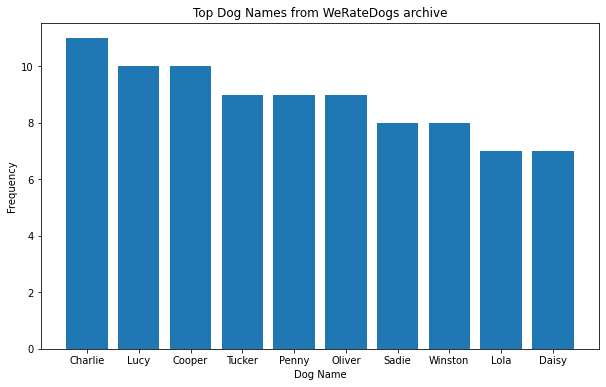

In [155]:
# calculate and keep top 10 dog names
names = archive_clean['name'].value_counts().nlargest(10).rename_axis('dog_name').reset_index(name='frequency')

# plot in a bar chart
plt.rcParams["figure.figsize"] = (10,6)
plt.bar(names['dog_name'], names['frequency'])
plt.xlabel("Dog Name")
plt.ylabel("Frequency")
plt.title("Top Dog Names from WeRateDogs archive")
plt.show()

##### Insight 2:

For the 10 most commonly posted breeds, the Samoyed was the most liked among WeRateDogs followers and fans. Each time a Samoyed image was posted, it garnered on average over 11,000 likes. This was followed by the Golden Retriever with an average of over 10,700 likes per post. The least liked dog that was among the 10 most commonly posted was the Pug, with just over 5,000 likes on average each time a Pug was posted.

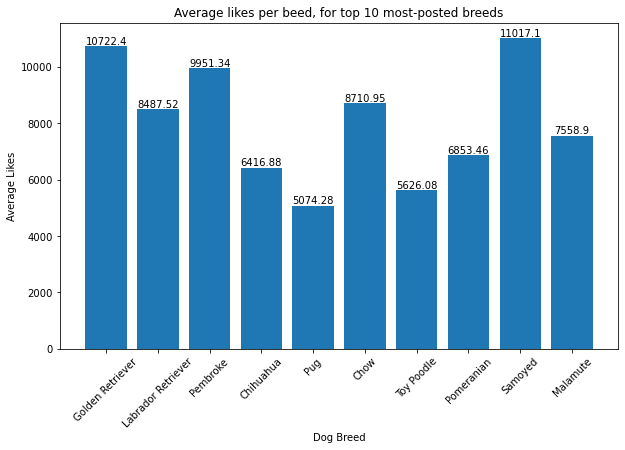

In [156]:
# calculate means for each breed
breed_likes = archive_clean.groupby(['predicted_breed']).mean().rename_axis('dog_breed').reset_index()

# calculate and keep top 10 breeds
top_breeds = archive_clean['predicted_breed'].value_counts().nlargest(10).rename_axis('dog_breed').reset_index(name='frequency')

# merge top 10 breeds with mean likes per breed
top_breeds = pd.merge(top_breeds, breed_likes[['dog_breed', 'public_metrics.like_count']], on='dog_breed', how='left')

# plot in a bar chart
blikes_chart = plt.bar(top_breeds['dog_breed'], top_breeds['public_metrics.like_count'])
plt.xlabel("Dog Breed")
plt.ylabel("Average Likes")
plt.title("Average likes per beed, for top 10 most-posted breeds")
plt.xticks(rotation = 45)
plt.bar_label(blikes_chart, label_type='edge')
plt.show()

##### Insight 3:

SkyNet isn't far away. The image prediction algorithm is gaining confidence over time, with a clear upward trend in the confidence of its dog breed predictions from late 2015 to mid-2017. What will happen once it is 100% confident?

Alternative explanations include better smartphone cameras over time, or better dog photography, allowing for better predictions.

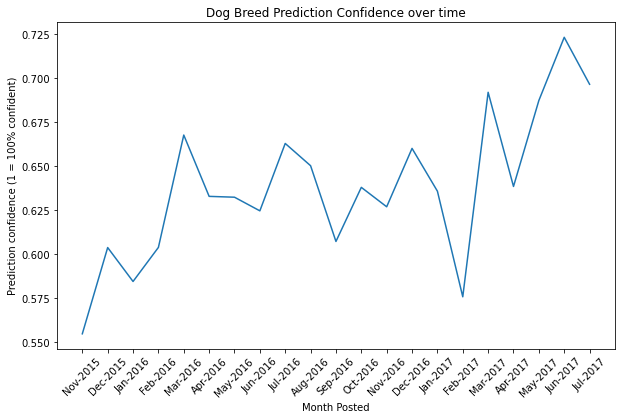

In [169]:
# extract timestamp and confidence
confidence_timeline = archive_clean.loc[:,['timestamp', 'prediction_confidence']]

# reduce timestamp down to month and year - numeric and label formats
confidence_timeline['date_plt'] = confidence_timeline['timestamp'].dt.strftime('%Y%m').astype(int)
confidence_timeline['date_label'] = confidence_timeline['timestamp'].dt.strftime('%b-%Y')
confidence_timeline.drop(columns='timestamp', inplace=True)

# calculate mean confidence per month
confidence_timeline = confidence_timeline.groupby(['date_plt', 'date_label']).mean().reset_index()
confidence_timeline.sort_values(by='date_plt', ascending=True)

# added this after charting - anomolous data, probably incomplete data for August 2017
confidence_timeline = confidence_timeline[(confidence_timeline['date_plt'] < 201708)]

# plot as a line graph
plt.plot(confidence_timeline['date_label'], confidence_timeline['prediction_confidence'])
plt.xlabel("Month Posted")
plt.ylabel("Prediction confidence (1 = 100% confident)")
plt.title("Dog Breed Prediction Confidence over time")
plt.xticks(rotation = 45)
plt.show()